In [1]:
import pandas as pd
import numpy as np

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.wrappers import TimeDistributed
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.preprocessing.sequence import pad_sequences
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers import Embedding, Dense, Dropout, Reshape, Merge, BatchNormalization, TimeDistributed, Lambda
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K


import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
K.set_session(tf.Session(config=config))

MAX_NB_WORDS = 100000
MAX_PARAGRAPH_LENGTH = 200
MAX_QUESTION_LENGTH = 30

X_train = pd.read_csv('../train_task_b.csv')


import pymorphy2
morph = pymorphy2.MorphAnalyzer()

Using TensorFlow backend.


In [2]:
word_tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, split=" ", char_level=False)
word_tokenizer.fit_on_texts(X_train.paragraph.tolist() + X_train.question.tolist())

train_sequences_1 = word_tokenizer.texts_to_sequences(X_train.paragraph.tolist())
train_sequences_2 = word_tokenizer.texts_to_sequences(X_train.question.tolist())
train_sequences_3 = word_tokenizer.texts_to_sequences(X_train.answer.tolist())

train_sequences_1 = pad_sequences(train_sequences_1, maxlen=MAX_PARAGRAPH_LENGTH)
train_sequences_2 = pad_sequences(train_sequences_2, maxlen=MAX_QUESTION_LENGTH)
#train_sequences_3 = pad_sequences(train_sequences_3, maxlen=MAX_QUESTION_LENGTH)
train_sequences_3 = np.array(train_sequences_3)


char_tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, split=" ", char_level=True)
char_tokenizer.fit_on_texts(X_train.paragraph + X_train.question)


def find(arr, sub_arr):
    for i in range(len(arr) - len(sub_arr)):
        flag = 1
        for j in range(len(sub_arr)):
            if arr[i + j] != sub_arr[j]:
                flag = 0
        if flag == 1:
            return i, i + len(sub_arr)
        
        
start_end = np.zeros([len(train_sequences_1),2])
for i in range(len(train_sequences_1)):
    start_end[i] = find(train_sequences_1[i], train_sequences_3[i])
    
    
from gensim.models import KeyedVectors

#word2vec = KeyedVectors.load_word2vec_format('../ruwikiruscorpora_0_300_20.bin', binary=True)
#word2vec = KeyedVectors.load_word2vec_format('../news_0_300_2.bin', binary=True)
word2vec = KeyedVectors.load_word2vec_format('../ruscorpora_1_600_2.bin', binary=True)     

In [3]:
X_train['paragraph'] = X_train['paragraph'].apply(lambda x: x.lower().split())
X_train['question'] = X_train['question'].apply(lambda x: x.lower().split())
X_train['answer'] = X_train['answer'].apply(lambda x: x.lower().split())

train_sequences_1_ = X_train.paragraph.apply(lambda x: pad_sequences(char_tokenizer.texts_to_sequences(x), maxlen=20).tolist()[-200:])
train_sequences_2_ = X_train.question.apply(lambda x: pad_sequences(char_tokenizer.texts_to_sequences(x), maxlen=20).tolist()[-30:])
train_sequences_3_ = X_train.answer.apply(lambda x: pad_sequences(char_tokenizer.texts_to_sequences(x), maxlen=20).tolist()[-30:])

In [4]:
tmp = train_sequences_1_.apply(lambda x: np.vstack((np.zeros([201-len(x), 20]),np.array(x))))
arr = []
for i in np.array(tmp):
    arr += [i.tolist()]
train_sequences_1_ = np.array(arr)

tmp = train_sequences_2_.apply(lambda x: np.vstack((np.zeros([31-len(x), 20]),np.array(x))))
arr = []
for i in np.array(tmp):
    arr += [i.tolist()]
train_sequences_2_ = np.array(arr)

tmp = train_sequences_3_.apply(lambda x: np.vstack((np.zeros([31-len(x), 20]),np.array(x))))
arr = []
for i in np.array(tmp):
    arr += [i.tolist()]
train_sequences_3_ = np.array(arr)


train_sequences_1_ = train_sequences_1_[:,:200,:]
train_sequences_2_ = train_sequences_2_[:,:30,:]
train_sequences_3_ = train_sequences_3_[:,:30,:]

In [5]:
word_index = char_tokenizer.word_index

embedding_char1 = Embedding(len(word_index),
                            30,
                            input_length=20,
                            trainable=True)

In [6]:
def get_vect(p):
    vect = []
    for i in list(p.KNOWN_GRAMMEMES):
        if i in p:
            vect += [1]
        else:
            vect += [0]
    return np.array(vect)

from tqdm import tqdm
word_index = word_tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, 720))
cnt = 0 
for word, i in tqdm(word_index.items()):
    p = morph.parse(word)[0]
    vect = get_vect(p.tag)
    word = p.normalized[0]
    for part_sp in p.tag.PARTS_OF_SPEECH:
        if word+'_'+part_sp in word2vec.vocab:
            embedding_matrix[i] = np.concatenate((word2vec.word_vec(word+'_'+part_sp), vect))
            #embedding_matrix[i] = word2vec.word_vec(word+'_'+part_sp)
            cnt += 1
            break

100%|██████████| 139609/139609 [00:41<00:00, 3384.85it/s]


In [7]:
embedding_layer1 = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            input_length=MAX_PARAGRAPH_LENGTH,
                            trainable=True)

embedding_layer2 = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            input_length=MAX_QUESTION_LENGTH,
                            trainable=True)

embedding_layer3 = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            input_length=1,
                            trainable=True)

In [8]:
in_answer = np.zeros([len(train_sequences_1),200])
idx = 0
for u, v in tqdm(zip(train_sequences_1,train_sequences_3)):
    tmp = []
    for i in u:
        tmp += [i in v]
    in_answer[idx] = tmp
    idx += 1

50364it [00:44, 1137.73it/s]


In [9]:
val_sequences_1_ = train_sequences_1_[40000:]
train_sequences_1_ = train_sequences_1_[:40000]

val_sequences_2_ = train_sequences_2_[40000:]
train_sequences_2_ = train_sequences_2_[:40000]

val_sequences_3_ = train_sequences_3_[40000:]
train_sequences_3_ = train_sequences_3_[:40000]



val_sequences_1 = train_sequences_1[40000:]
train_sequences_1 = train_sequences_1[:40000]

val_sequences_2 = train_sequences_2[40000:]
train_sequences_2 = train_sequences_2[:40000]

val_sequences_3 = train_sequences_3[40000:]
train_sequences_3 = train_sequences_3[:40000]

start_end_val = start_end[40000:]
start_end_train = start_end[:40000]

in_answer_val = in_answer[40000:]
in_answer_train = in_answer[:40000]

# Эксперименты

In [10]:
from keras import backend as K
import numpy as np
from keras.layers import add
from keras.layers.core import Reshape
from keras.layers.wrappers import Bidirectional 
from keras.layers import multiply, average
import keras.backend as K
import numpy as np



from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *
from keras.layers import Concatenate

INPUT_DIM = 2
TIME_STEPS = 20
# if True, the attention vector is shared across the input_dimensions where the attention is applied.
SINGLE_ATTENTION_VECTOR = False
APPLY_ATTENTION_BEFORE_LSTM = False
 

def attention_3d_block230(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, 230))(a)
    a = Dense(230, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec230')(a)
    output_attention_mul = merge([inputs, a_probs], name='attention_mul230', mode='mul')
    return output_attention_mul

def attention_3d_block200(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, 200))(a)
    a = Dense(200, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec200')(a)
    output_attention_mul = merge([inputs, a_probs], name='attention_mul200', mode='mul')
    return output_attention_mul



In [9]:
def slice(x):
    return x[:, :200, :]

In [10]:
def slice1(x):
    return x[:, 200:, :]

In [11]:
def slice2(x):
    return x[:, :20, :]

In [12]:
def get(x, i):
    return x[:, i, :]

In [8]:
import tensorflow as tf

In [11]:
from keras import backend as K
from keras.engine.topology import Layer
import numpy as np
from keras.layers import multiply, Multiply
LSTM_DIM=150

class MyLayer(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(LSTM_DIM, self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(MyLayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):        
        #return tf.multiply(x, self.kernel)
        return x*self.kernel


    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [12]:
def K_sqrt(x):
    return K.sqrt(x)

def K_mul(x):
    return x[0]*x[1]

def K_cos(x):
    return x[0] / (x[1] + x[2])

In [14]:
import keras
def ker(x):
    x1 = x[0]
    x1 = Reshape((200, LSTM_DIM, 1))(x1)
    x1 = concatenate([x1]*30, axis=3) 
    
    x2 = x[1]
    x2 = Reshape((30, LSTM_DIM, 1))(x2)
    x2 = concatenate([x2]*200, axis=3) 
    x2 = Reshape((200, 30, LSTM_DIM))(x2)
    x1 = Reshape((200, 30, LSTM_DIM))(x1)
    m = multiply([x1, x2])
    matr = concatenate([x1, x2, m])

    #matr = TimeDistributed(Dense(1),input_shape=(200, 30))(matr)  

    matr = Dense(1)(matr)  
    matr = Reshape((200, 30))(matr)
    
    res1 = keras.backend.max(matr, axis=2) 
    res1 = Dense(200, activation='softmax')(res1)
    res1 = Reshape((1,200))(res1)
    res1 = K.batch_dot(res1, x[0])
    res1 = concatenate([res1]*200,axis=1)
    res2 = Dense(30, activation='softmax')(matr)
    res2 = K.batch_dot(res2, x[1])
    
    res = concatenate([res1, res2], axis=2)
    return res

In [15]:
from keras.layers.merge import concatenate
from keras.layers import multiply, average,Multiply
from keras.layers import dot, merge

LSTM_DIM=100
W_DIM = 40

ch_lstm_p = LSTM(30, return_sequences=False)
ch_input_p = Input(shape=(200,20,), dtype='int32')
ch_emb_p = TimeDistributed(embedding_char1)(ch_input_p)
ch_repr_p = TimeDistributed(ch_lstm_p)(ch_emb_p)


ch_lstm_q = LSTM(30, return_sequences=False)
ch_input_q = Input(shape=(30,20,), dtype='int32')
ch_emb_q = TimeDistributed(embedding_char1)(ch_input_q)
ch_repr_q = TimeDistributed(ch_lstm_q)(ch_emb_q)


lstm_layer1_1 = LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2,return_sequences=True, go_backwards=False)
lstm_layer1_1_rev = LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2,return_sequences=True, go_backwards=True)

lstm_layer1_2 = Bidirectional(LSTM(200, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
lstm_layer1_3 = Bidirectional(LSTM(200, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))

lstm_layer2_1 = LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2,return_sequences=True, go_backwards=False)
lstm_layer2_1_rev = LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2,return_sequences=True, go_backwards=True)

lstm_layer2_1_ = LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2,return_sequences=False, go_backwards=False)
lstm_layer2_1_rev_ = LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2,return_sequences=False, go_backwards=True)
#lstm_layer2_2 = LSTM(200, dropout=0.2, recurrent_dropout=0.2,return_sequences=False)


in_answer_input = Input(shape=(MAX_PARAGRAPH_LENGTH,), dtype='float32')
in_answer_ = Reshape((200,1))(in_answer_input)

sequence_1_input = Input(shape=(MAX_PARAGRAPH_LENGTH,), dtype='int32')
embedded_sequences_1 = embedding_layer1(sequence_1_input)
embedded_sequences_1 = concatenate([embedded_sequences_1, ch_repr_p,in_answer_],axis=2)


p = lstm_layer1_1(embedded_sequences_1)
p_rev = lstm_layer1_1_rev(embedded_sequences_1)
#p_bi = concatenate([p, p_rev],axis=2)


p1 = Reshape((200, LSTM_DIM, 1))(p)
p1 = concatenate([p1]*W_DIM, axis=3)

p2 = Reshape((200, LSTM_DIM, 1))(p_rev)
p2 = concatenate([p2]*W_DIM, axis=3)

p3 = Reshape((200, LSTM_DIM, 1))(p)
p3 = concatenate([p3]*W_DIM, axis=3)
p3 = Reshape((200, LSTM_DIM, W_DIM, 1))(p3)
p3 = concatenate([p3]*30, axis=4)
p3 = Reshape((200, 30, LSTM_DIM,W_DIM))(p3)

p4 = Reshape((200, LSTM_DIM, 1))(p_rev)
p4 = concatenate([p4]*W_DIM, axis=3)
p4 = Reshape((200, LSTM_DIM, W_DIM, 1))(p4)
p4 = concatenate([p4]*30, axis=4)
p4 = Reshape((200, 30, LSTM_DIM,W_DIM))(p4)


sequence_2_input = Input(shape=(MAX_QUESTION_LENGTH,), dtype='int32')
embedded_sequences_2 = embedding_layer2(sequence_2_input)
embedded_sequences_2 = concatenate([embedded_sequences_2, ch_repr_q],axis=2)


q_ = lstm_layer2_1_(embedded_sequences_2)
q_rev_ = lstm_layer2_1_rev_(embedded_sequences_2)
q = lstm_layer2_1(embedded_sequences_2)
q_rev = lstm_layer2_1_rev(embedded_sequences_2)

q1 = Reshape((1, LSTM_DIM))(q_)
q1 = concatenate([q1]*200, axis=1)
q1 = Reshape((200, LSTM_DIM, 1))(q1)
q1 = concatenate([q1]*W_DIM, axis=3)

q2 = Reshape((1, LSTM_DIM))(q_rev_)
q2 = concatenate([q2]*200, axis=1)
q2 = Reshape((200, LSTM_DIM, 1))(q2)
q2 = concatenate([q2]*W_DIM, axis=3)

q3 = Reshape((30, LSTM_DIM))(q)
q3 = concatenate([q3]*200, axis=1)
q3 = Reshape((200, 30, LSTM_DIM, 1))(q3)
q3 = concatenate([q3]*W_DIM, axis=4)

q4 = Reshape((30, LSTM_DIM))(q_rev)
q4 = concatenate([q4]*200, axis=1)
q4 = Reshape((200, 30, LSTM_DIM, 1))(q4)
q4 = concatenate([q4]*W_DIM, axis=4)

att = Lambda(ker)([p, q])


#########################################
W1 = MyLayer(W_DIM)
p1 = W1(p1)
q1 = W1(q1)

m1 = Lambda(K_mul)([p1, q1])
m1 = Lambda(lambda x: K.sum(x, axis=2), output_shape=(200, W_DIM))(m1)

p1_norm = Lambda(K_mul)([p1,p1])
p1_norm = Lambda(lambda x: K.sum(x, axis=2), output_shape=(200, W_DIM))(p1_norm)
p1_norm = Lambda(K_sqrt)(p1_norm)

q1_norm = Lambda(K_mul)([q1,q1])
q1_norm = Lambda(lambda x: K.sum(x, axis=2), output_shape=(200, W_DIM))(q1_norm)
q1_norm = Lambda(K_sqrt)(q1_norm)

m1 = Lambda(K_cos)([m1, p1_norm, q1_norm])

#########################################
W2 = MyLayer(W_DIM)
p2 = W2(p2)
q2 = W2(q2)

m2 = Lambda(K_mul)([p2, q2])
m2 = Lambda(lambda x: K.sum(x, axis=2), output_shape=(200, W_DIM))(m2)

p2_norm = Lambda(K_mul)([p2,p2])
p2_norm = Lambda(lambda x: K.sum(x, axis=2), output_shape=(200, W_DIM))(p2_norm)
p2_norm = Lambda(K_sqrt)(p2_norm)

q2_norm = Lambda(K_mul)([q2,q2])
q2_norm = Lambda(lambda x: K.sum(x, axis=2), output_shape=(200, W_DIM))(q2_norm)
q2_norm = Lambda(K_sqrt)(q2_norm)

m2 = Lambda(K_cos)([m2, p2_norm, q2_norm])



#########################################
W3 = MyLayer(W_DIM)
p3 = W3(p3)
q3 = W3(q3)

m3 = Lambda(K_mul)([p3, q3])
m3 = Lambda(lambda x: K.sum(x, axis=3), output_shape=(200, 30, W_DIM))(m3)

p3_norm = Lambda(K_mul)([p3,p3])
p3_norm = Lambda(lambda x: K.sum(x, axis=3), output_shape=(200, 30, W_DIM))(p3_norm)
p3_norm = Lambda(K_sqrt)(p3_norm)

q3_norm = Lambda(K_mul)([q3,q3])
q3_norm = Lambda(lambda x: K.sum(x, axis=3), output_shape=(200, 30, W_DIM))(q3_norm)
q3_norm = Lambda(K_sqrt)(q3_norm)

m3 = Lambda(K_cos)([m3, p3_norm, q3_norm])
m3 = Lambda(lambda x: K.max(x, axis=2), output_shape=(200, W_DIM))(m3)
#########################################
W4 = MyLayer(W_DIM)
p4 = W4(p4)
q4 = W4(q4)

m4 = Lambda(K_mul)([p4, q4])
m4 = Lambda(lambda x: K.sum(x, axis=3), output_shape=(200, 30, W_DIM))(m4)

p4_norm = Lambda(K_mul)([p4,p4])
p4_norm = Lambda(lambda x: K.sum(x, axis=3), output_shape=(200, 30, W_DIM))(p4_norm)
p4_norm = Lambda(K_sqrt)(p4_norm)

q4_norm = Lambda(K_mul)([q4,q4])
q4_norm = Lambda(lambda x: K.sum(x, axis=3), output_shape=(200, 30, W_DIM))(q4_norm)
q4_norm = Lambda(K_sqrt)(q4_norm)

m4 = Lambda(K_cos)([m4, p4_norm, q4_norm])
m4 = Lambda(lambda x: K.max(x, axis=2), output_shape=(200, W_DIM))(m4)
#########################################
'''
W5 = MyLayer(W_DIM)
p5 = W5(p3)
q5 = W5(q3)

m5 = Lambda(K_mul)([p5, q5])
m5 = Lambda(lambda x: K.sum(x, axis=3), output_shape=(200, 30, W_DIM))(m5)

p5_norm = Lambda(K_mul)([p5,p5])
p5_norm = Lambda(lambda x: K.sum(x, axis=3), output_shape=(200, 30, W_DIM))(p5_norm)
p5_norm = Lambda(K_sqrt)(p5_norm)

q5_norm = Lambda(K_mul)([q5,q5])
q5_norm = Lambda(lambda x: K.sum(x, axis=3), output_shape=(200, 30, W_DIM))(q5_norm)
q5_norm = Lambda(K_sqrt)(q5_norm)

m5 = Lambda(K_cos)([m5, p5_norm, q5_norm])
m5 = Lambda(lambda x: K.mean(x, axis=2), output_shape=(200, W_DIM))(m5)
#########################################
W6 = MyLayer(W_DIM)
p6 = W6(p4)
q6 = W6(q4)

m6 = Lambda(K_mul)([p6, q6])
m6 = Lambda(lambda x: K.sum(x, axis=3), output_shape=(200, 30, W_DIM))(m6)

p6_norm = Lambda(K_mul)([p6,p6])
p6_norm = Lambda(lambda x: K.sum(x, axis=3), output_shape=(200, 30, W_DIM))(p6_norm)
p6_norm = Lambda(K_sqrt)(p6_norm)

q6_norm = Lambda(K_mul)([q6,q6])
q6_norm = Lambda(lambda x: K.sum(x, axis=3), output_shape=(200, 30, W_DIM))(q6_norm)
q6_norm = Lambda(K_sqrt)(q6_norm)

m6 = Lambda(K_cos)([m6, p6_norm, q6_norm])
m6 = Lambda(lambda x: K.mean(x, axis=2), output_shape=(200, W_DIM))(m6)
#########################################


'''


merged = concatenate([p,p_rev, m1,m2,m3,m4,att],axis=2)
merged = lstm_layer1_2(merged)
#merged = lstm_layer1_3(merged)
#merged = attention_3d_block200(merged)
merged = Dense(240, activation='relu')(merged)
merged = Dropout(0.1)(merged)
merged = Dense(120, activation='relu')(merged)
merged = Dropout(0.2)(merged)
preds = Dense(1, activation='sigmoid')(merged)

In [32]:
in_answer_input

<tf.Tensor 'input_7:0' shape=(?, 200) dtype=int32>

In [13]:
m4

<tf.Tensor 'lambda_38/Max:0' shape=(?, 200, 70) dtype=float32>

In [27]:
p3_norm

<tf.Tensor 'lambda_68/Sqrt:0' shape=(?, 200, 30, 70) dtype=float32>

In [21]:
q3

<tf.Tensor 'concatenate_46/concat:0' shape=(?, 200, 30, 90, 70) dtype=float32>

In [72]:
p1_norm

<tf.Tensor 'lambda_60/Sqrt:0' shape=(?, 200, 70) dtype=float32>

In [27]:
import keras
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0,clipvalue=1.0)
sgd = keras.optimizers.SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)


model = Model(inputs=[sequence_1_input,ch_input_p, sequence_2_input, ch_input_q, in_answer_input], \
        outputs=[preds])
model.compile(loss='binary_crossentropy',
        optimizer=adam,
        metrics=['acc'])

model_checkpoint = ModelCheckpoint('IBM_char_copy.h5', save_best_only=True, save_weights_only=True, monitor='val_loss')

In [40]:
model.predict([x_train1, x_train2]).shape

(20, 230, 1)

In [28]:
model.load_weights('IBM_char_copy.h5')

In [25]:
import random
random.randint(0,1)

1

In [22]:
def all_generator(batch_size, tr_p, tr_p_, tr_q, tr_q_, st_end, in_ans_):
    while(1):
        idx = np.array(range(tr_p.shape[0]))
        np.random.shuffle(idx)
        x_train1 = np.zeros([batch_size, MAX_PARAGRAPH_LENGTH])
        x_train1_ = np.zeros([batch_size, MAX_PARAGRAPH_LENGTH, 20])

        x_train2 = np.zeros([batch_size, 30])
        x_train2_ = np.zeros([batch_size, 30, 20])
        #x_train3 = np.zeros([batch_size, 30])
        x_train3 = np.zeros([batch_size,200])

        y_train = np.zeros([batch_size,200,1])

        curr_batch_size = 0
        for i in range(batch_size):
            y = []
            a = []
            for j in range(200):
                y += [j == st_end[idx[i]][0]]
                #y += [[j == st_end[idx[i]][0], j == st_end[idx[i]][1]- 1]]
                #y += [j >= st_end[idx[i]][0] and j < st_end[idx[i]][1]]
                a += [tr_p[idx[i]][j] in tr_q[idx[i]]]
            x_train1[i] = tr_p[idx[i]]
            x_train2[i] = tr_q[idx[i]]
            
            x_train1_[i] = tr_p_[idx[i]]
            x_train2_[i] = tr_q_[idx[i]]

            x_train3[i] = np.array(a)#.reshape(200,1)
            
            y_train[i] = np.array(y).reshape(200,1)

        yield ([x_train1, x_train1_, x_train2, x_train2_, x_train3], y_train)

In [21]:
train_sequences_3_.shape

(40000, 30, 20)

In [ ]:
batch_size = 1
model.fit_generator(all_generator(batch_size, train_sequences_1,train_sequences_1_,
                                  train_sequences_2,train_sequences_2_,
                                  start_end_train, in_answer_train),
                    samples_per_epoch=100,
                    validation_data=all_generator(batch_size,val_sequences_1,
                                                  val_sequences_1_,val_sequences_2,
                                                  val_sequences_2_,start_end_val, in_answer_val),
                    nb_val_samples=100,
                    nb_epoch=40,
                    verbose=1,
                    callbacks=[model_checkpoint])

/home/afattahov/.local/lib/python3.5/site-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument  `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Update your method calls accordingly.
  if sys.path[0] == '':
/home/afattahov/.local/lib/python3.5/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., callbacks=[<keras.ca..., validation_steps=100, steps_per_epoch=100, epochs=40, verbose=1)`
  if sys.path[0] == '':
/home/afattahov/tf3/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 100519200 elements. This may consume a large amount of memory.
  "This may consume a large amount of memory." % num_elements)


Epoch 1/40
100/100 [==============================] - 147s - loss: 0.0214 - acc: 0.9954 - val_loss: 0.0192 - val_acc: 0.9953
Epoch 2/40
100/100 [==============================] - 138s - loss: 0.0198 - acc: 0.9953 - val_loss: 0.0204 - val_acc: 0.9951
Epoch 3/40
100/100 [==============================] - 137s - loss: 0.0215 - acc: 0.9953 - val_loss: 0.0213 - val_acc: 0.9951
Epoch 4/40
100/100 [==============================] - 141s - loss: 0.0202 - acc: 0.9953 - val_loss: 0.0190 - val_acc: 0.9954
Epoch 5/40
100/100 [==============================] - 142s - loss: 0.0197 - acc: 0.9953 - val_loss: 0.0190 - val_acc: 0.9952
Epoch 6/40
100/100 [==============================] - 141s - loss: 0.0196 - acc: 0.9952 - val_loss: 0.0251 - val_acc: 0.9952
Epoch 7/40
100/100 [==============================] - 139s - loss: 0.0254 - acc: 0.9952 - val_loss: 0.0305 - val_acc: 0.9951
Epoch 8/40
100/100 [==============================] - 140s - loss: 0.0289 - acc: 0.9954 - val_loss: 0.0285 - val_acc: 0.9953


In [ ]:
import keras
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0,clipvalue=1.0)
sgd = keras.optimizers.SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)


model = Model(inputs=[sequence_1_input,ch_input_p, sequence_2_input, ch_input_q, in_answer_input], \
        outputs=[preds])
model.compile(loss='binary_crossentropy',
        optimizer=adam,
        metrics=['acc'])

model_checkpoint = ModelCheckpoint('IBM_char_copy.h5', save_best_only=True, save_weights_only=True, monitor='val_loss')


batch_size = 1
model.fit_generator(all_generator(batch_size, train_sequences_1,train_sequences_1_,
                                  train_sequences_2,train_sequences_2_,
                                  start_end_train, in_answer_train),
                    samples_per_epoch=100,
                    validation_data=all_generator(batch_size,val_sequences_1,
                                                  val_sequences_1_,val_sequences_2,
                                                  val_sequences_2_,start_end_val, in_answer_val),
                    nb_val_samples=100,
                    nb_epoch=60,
                    verbose=1,
                    callbacks=[model_checkpoint])

In [54]:
model.save_weights('IBM_char1.h5')

In [23]:
model.load_weights('IBM_char_copy.h5')

In [38]:
pred = model.predict([x_train1,x_train2])    

In [45]:
pred.shape

(20, 200, 2)

In [22]:
batch = len(val_sequences_1)
batch = 5
x_train1 = np.zeros([batch,MAX_PARAGRAPH_LENGTH])
x_train2 = np.zeros([batch,30])
x_train3 = np.zeros([batch,200])

x_train1_ = np.zeros([batch,MAX_PARAGRAPH_LENGTH, 20])
x_train2_ = np.zeros([batch,30, 20])

st_end = np.zeros([batch,2])

for i in range(batch):
    x_train1[i] = val_sequences_1[i]
    x_train2[i] = val_sequences_2[i]
    x_train3[i] = in_answer_val[i]
        
    x_train1_[i] = val_sequences_1_[i]
    x_train2_[i] = val_sequences_2_[i]
    
    st_end[i] = start_end_val[i]

    
    
pred = model.predict([x_train1, x_train1_, x_train2, x_train2_, in_answer_val])    
    
real_arr = []
for i in range(batch):
    real = []
    for j in range(200):
        real += [float(j >= st_end[i][0] and j < st_end[i][1]) / 5.0]
        #real += [float(j == st_end[i][1]-1) / 5.0]

    tmp = real
    real_arr += [tmp]

In [58]:
batch = len(val_sequences_1)
batch = 20
x_train1 = np.zeros([batch,MAX_PARAGRAPH_LENGTH])
x_train2 = np.zeros([batch,30])
x_train3 = np.zeros([batch,200])

x_train1_ = np.zeros([batch,MAX_PARAGRAPH_LENGTH, 20])
x_train2_ = np.zeros([batch,30, 20])

st_end = np.zeros([batch,2])

for i in range(batch):
    x_train1[i] = train_sequences_1[i]
    x_train2[i] = train_sequences_2[i]
    x_train3[i] = in_answer_train[i]
        
    x_train1_[i] = train_sequences_1_[i]
    x_train2_[i] = train_sequences_2_[i]
    
    st_end[i] = start_end_val[i]

    
    
pred = model.predict([x_train1, x_train1_, x_train2, x_train2_, in_answer_train])    
    
real_arr = []
for i in range(batch):
    real = []
    for j in range(200):
        real += [float(j >= st_end[i][0] and j < st_end[i][1]) / 5.0]
        #real += [float(j == st_end[i][1]-1) / 5.0]

    tmp = real
    real_arr += [tmp]

Populating the interactive namespace from numpy and matplotlib


/home/afattahov/tf3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['real']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


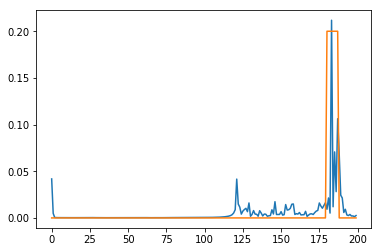

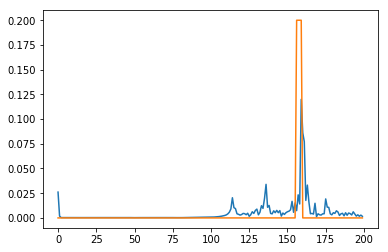

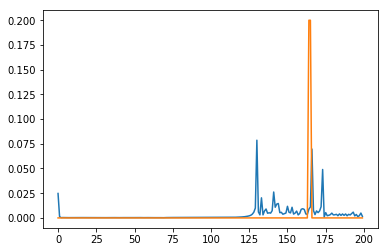

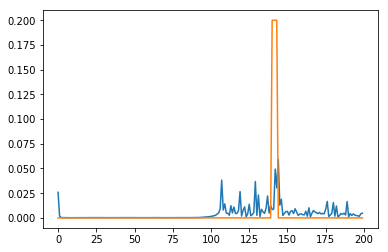

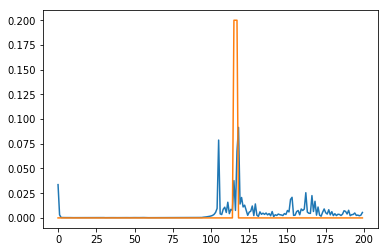

In [23]:
%matplotlib inline
%pylab inline
for i in range(batch):
    #plt.plot(range(200), pred2[i].reshape(200))
    plt.plot(range(200), pred[i].reshape(200))
    plt.plot(range(200), real_arr[i])

    plt.show()

Populating the interactive namespace from numpy and matplotlib


/home/afattahov/tf3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['concatenate', 'average', 'dot', 'real', 'multiply']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


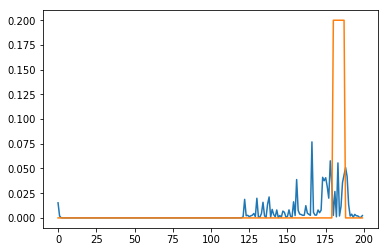

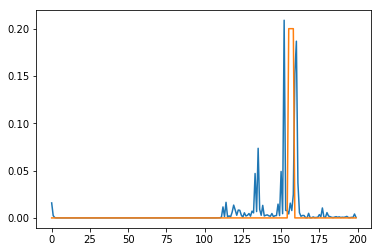

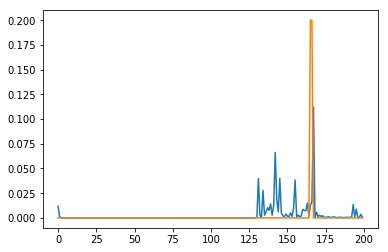

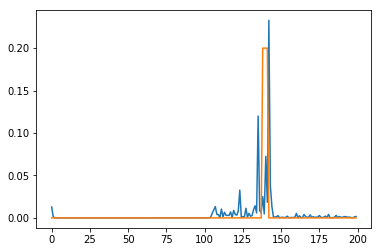

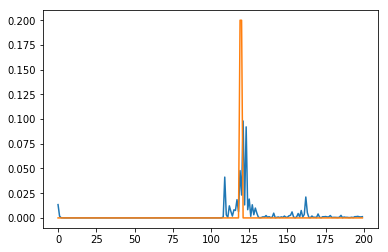

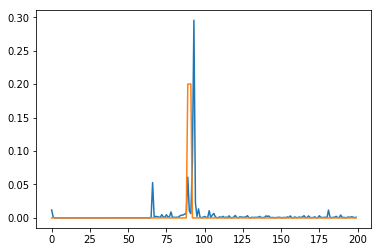

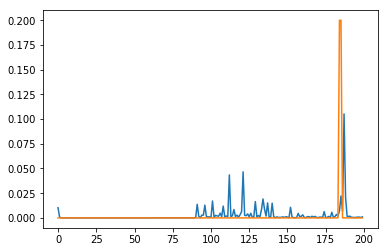

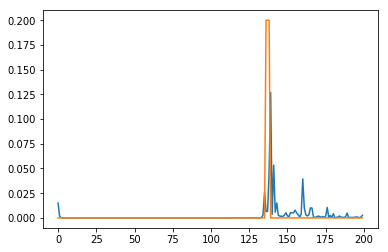

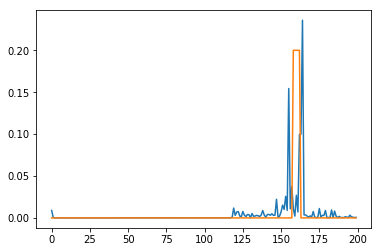

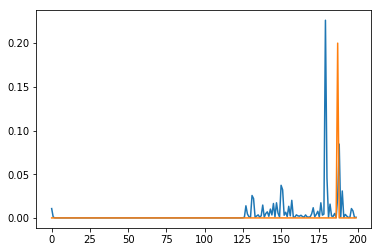

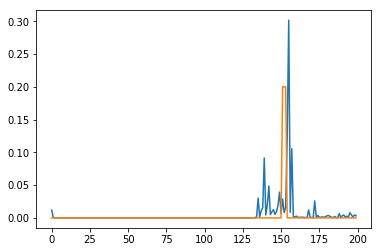

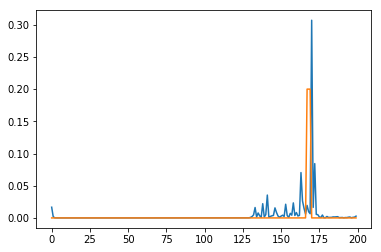

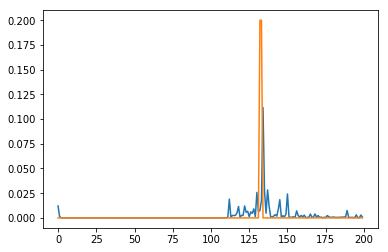

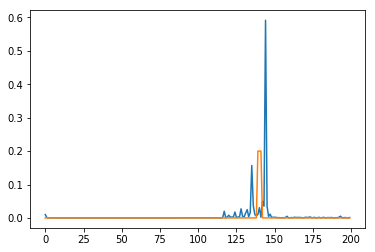

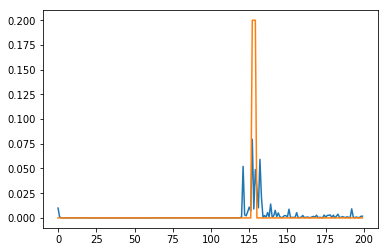

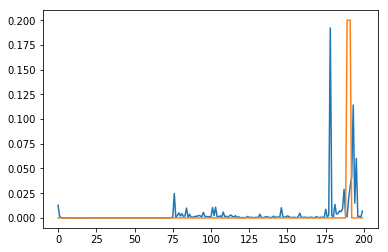

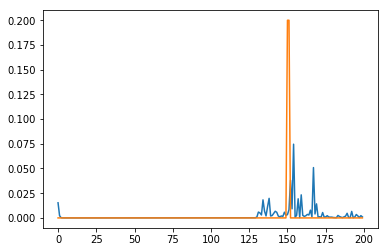

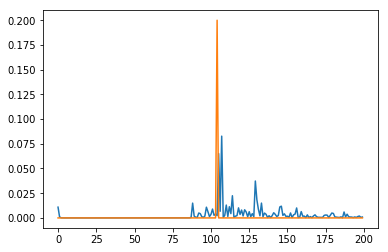

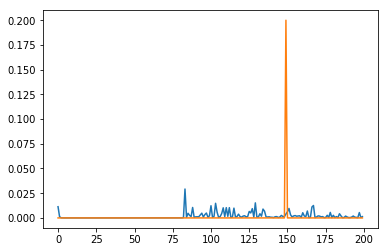

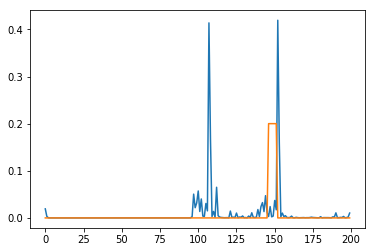

In [53]:
%matplotlib inline
%pylab inline
for i in range(batch):
    #plt.plot(range(200), pred2[i].reshape(200))
    plt.plot(range(200), pred[i].reshape(200))
    plt.plot(range(200), real_arr[i])

    plt.show()

In [178]:
mask = pred > 0.09

predict = []
for i in range(len(val_sequences_1)):
    predict += [val_sequences_1[i][mask[i]]]

In [179]:
predict[0]

array([ 3182,     5,  3324, 15426,     2, 25770,  3836,  3665, 33643,
       38453,  1475,   962,   463,     3, 38478,  5317,  1336,  8667,
           2, 13692], dtype=int32)

In [180]:
def f1_score(prediction, ground_truth):
    if len(prediction) == 0:
        return 0
    if len(ground_truth) == 0:
        return 0
    precision = 1.0 * len(list(set(prediction) & set(ground_truth))) / len(prediction)
    recall = 1.0 * len(list(set(prediction) & set(ground_truth))) / len(ground_truth)
    if precision + recall != 0:
        f1 = (2 * precision * recall) / (precision + recall)
    else:
        f1 = 0
    return f1

In [136]:
f1_score(tmp, tmp1)

0.46153846153846156

In [181]:
f1_score(predict[0], val_sequences_3[0])

0.35714285714285715

In [182]:
f1 = []
for i in range(len(predict)):
    f1 += [f1_score(predict[i], val_sequences_3[i])]

In [183]:
np.array(f1).mean()

0.094258449787767276